<a href="https://colab.research.google.com/github/MateoPeri/steel-scrap-predictor/blob/merge-data/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import glob

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet
import matplotlib.pyplot as plt
import altair as alt
plt.style.use('seaborn-poster')

# Data preparation

In [2]:
!rm -rf '/content/data'
!mkdir data
PATH = '/content/data/'
!wget -P {PATH} https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
!unzip {PATH}raw.zip

--2020-06-07 09:44:54--  https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240524 (235K) [application/zip]
Saving to: ‘/content/data/raw.zip’

raw.zip             100%[===================>] 234.89K  --.-KB/s    in 0.05s   

2020-06-07 09:44:54 (4.69 MB/s) - ‘/content/data/raw.zip’ saved [240524/240524]

Archive:  /content/data/raw.zip
   creating: raw/
  inflating: raw/HC Closing Prices.xlsx  
  inflating: raw/HC Final Settlement prices.xlsx  
  inflating: raw/HU Closing Prices.xlsx  
  inflating: raw/HU Final Settlement prices.xlsx  
  inflating: raw/SC Closing Prices.xlsx  
  inflating: raw/SC Final Settlement prices.xlsx  
  inflating: raw/SR Closing Prices.xlsx  
  inflating: 

In [0]:
def st_to_mt(st):
  return st/1.10231131

In [70]:
pattern = 'raw/*Closing Prices.xlsx'
excels = glob.glob(pattern)

frames = []
to_keep = 'M1'

for xcel in excels:
  df = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  # le añadimos un nombre para saber qué metal es
  name = xcel[4:6]
  if (name == 'HU'):
    # Seleccionar todas las columnas menos USD/st
    cols = [c for c in df.columns if c != 'USD/st (Short Ton)']
    # y aplicarles la funcion st_to_mt para pasar a toneladas métricas
    df[cols] = df[cols].apply(st_to_mt, axis=1)
    # Cambiamos el nombre a la columna
    df.rename({'USD/st (Short Ton)': 'USD/mt'}, axis=1, inplace=True)
  
  df.rename({'USD/mt': 'Date', to_keep: name}, axis=1, inplace=True)
  df = df[['Date', name]]
  
  frames.append(df)

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames]
df = pd.concat(dfs, axis=1)

df.head()

,SR,SC,HU,HC
Date,,,,
2015-11-23,338.0,195.0,NaN,NaN
2015-11-24,337.0,195.0,NaN,NaN
2015-11-25,335.0,195.0,NaN,NaN
2015-11-26,334.0,192.0,NaN,NaN
2015-11-27,334.0,192.0,NaN,NaN


In [71]:
# Cuando empiezan los valores de HU y HC -> 2019-03-11
df = df.loc[df.HU.notna() | df.HC.notna()]
df.head()

,SR,SC,HU,HC
Date,,,,
2019-03-11,478.0,327.0,638.204465,525.0
2019-03-12,481.0,327.0,638.204465,526.0
2019-03-13,481.0,327.0,636.843688,528.0
2019-03-14,481.0,327.0,635.029319,531.0
2019-03-15,476.0,326.5,637.750873,533.0


In [72]:
# Contamos los valores nulos del dataset -> 0
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2019-03-11 to 2020-05-05
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SR      292 non-null    float64
 1   SC      292 non-null    float64
 2   HU      292 non-null    float64
 3   HC      292 non-null    float64
dtypes: float64(4)
memory usage: 11.4 KB


# Data visualization

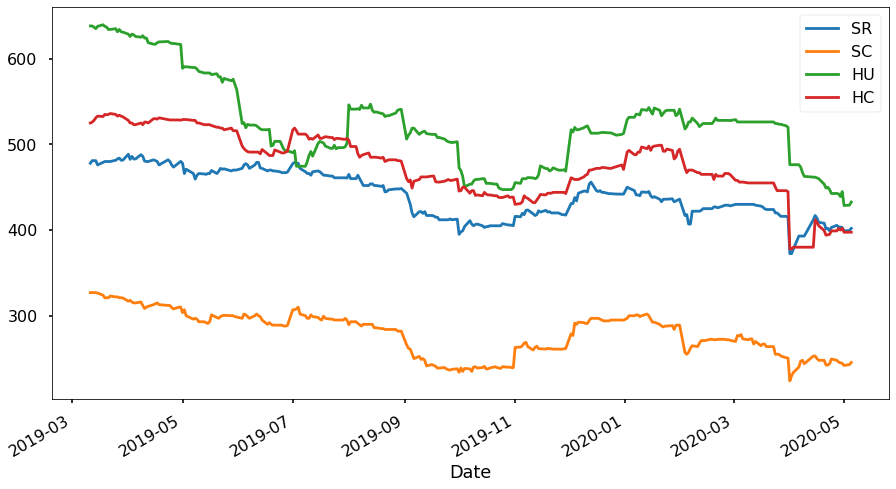

In [73]:
df.plot(figsize=(15,8))

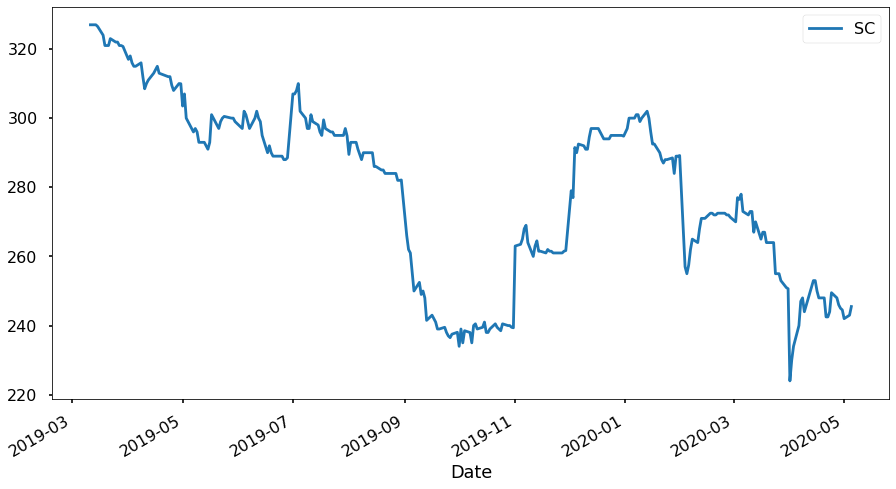

In [74]:
df[['SC']].plot(figsize=(15,8))

# Model

In [0]:
#data = df[['Date', 'M3', 'Metal']].copy()
data = df.reset_index().copy()
data.rename({'Date': 'ds', 'SC': 'y'}, axis=1, inplace=True)
data = data[['ds', 'y']]

In [0]:
def generate_model(dff):
  fecha = '2019-03-11'

  df_prediccion = dff.loc[dff.ds > fecha].copy()

  p_max = df_prediccion['y'].max()
  p_min = df_prediccion['y'].min()

  df_prediccion['cap'] = p_max
  df_prediccion['floor'] = p_min

  modelo_futuro = Prophet(growth='logistic', seasonality_mode='additive', changepoint_prior_scale=0.05, yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False
            ).add_seasonality(name='daily', period=1,fourier_order=3, prior_scale=0.2
            ).add_seasonality(name='weekly', period=7,fourier_order=3, prior_scale=0.2
            ).add_seasonality(name='monthly', period=30.50,fourier_order=3, prior_scale=0.2
            ).add_seasonality(name='quaterly', period=365.25/4,fourier_order=3, prior_scale=0.1
            ).add_seasonality(name='yearly', period=365.25,fourier_order=4, prior_scale=0.2)
  return modelo_futuro, df_prediccion

In [90]:
df_pred.head()

,ds,SR,y,HU,HC,cap,floor
1,2019-03-12,481.0,327.0,638.204465,526.0,327.0,224.0
2,2019-03-13,481.0,327.0,636.843688,528.0,327.0,224.0
3,2019-03-14,481.0,327.0,635.029319,531.0,327.0,224.0
4,2019-03-15,476.0,326.5,637.750873,533.0,327.0,224.0
5,2019-03-18,479.0,324.0,639.565242,532.5,327.0,224.0


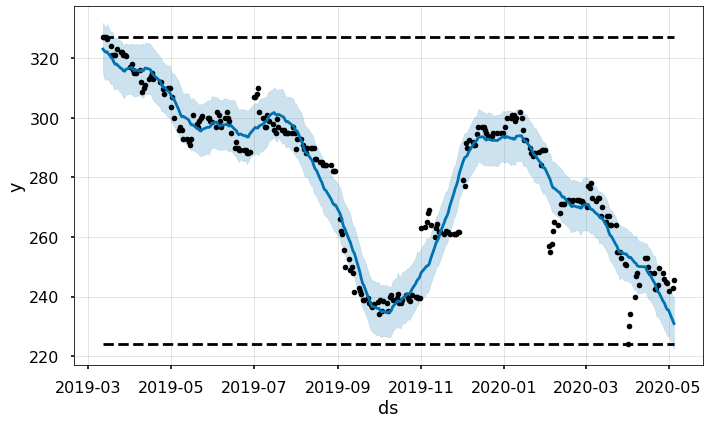

In [91]:
model, df_pred = generate_model(data)
model.fit(df_pred)
forecast = model.predict(df_pred)
fig = model.plot(forecast)

In [92]:
forecast['fact'] = df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(forecast.fact, forecast.yhat)*100))

Accuracy: 93.10%


In [0]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] == -1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

In [94]:
pred = detect_anomalies(forecast)
print(len(pred))
pred = pred[pred.anomaly==0]
print('Accuracy: {:.2f}%'.format(r2_score(pred.fact, pred.yhat)*100))

291
Accuracy: 97.38%


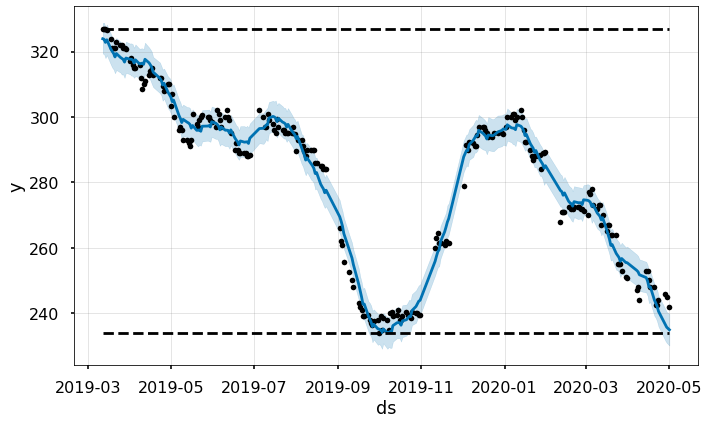

In [95]:
clean_df = pred[['ds', 'fact']]
clean_df.columns = ['ds', 'y']
clean_model, clean_df_pred = generate_model(clean_df.copy())
clean_model.fit(clean_df_pred)
clean_forecast = clean_model.predict(clean_df_pred)
fig2 = clean_model.plot(clean_forecast)

In [96]:
clean_forecast['fact'] = clean_df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(clean_forecast.fact, clean_forecast.yhat)*100))

Accuracy: 97.91%


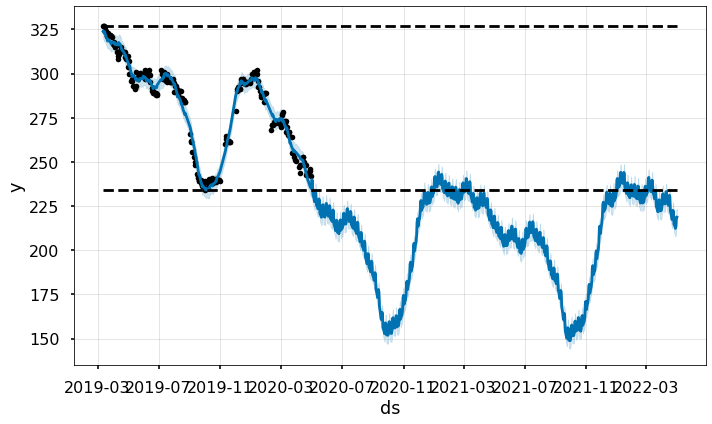

In [97]:
# 2 more years from end of data
future = clean_model.make_future_dataframe(periods=730, freq='d')

p_max = clean_df['y'].max()
p_min = clean_df['y'].min()
future['cap'] = p_max
future['floor'] = p_min
future_forecast = clean_model.predict(future)
fig = clean_model.plot(future_forecast)